<h1><center>IE 313 Time Series Analysis: Code Implementation Assignment #3</center></h1>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#LSTM-Model-Explanation" data-toc-modified-id="LSTM-Model-Explanation-1">LSTM Model Explanation</a></span><ul class="toc-item"><li><span><a href="#Long-Short-Term-Memory-(LSTM)" data-toc-modified-id="Long-Short-Term-Memory-(LSTM)-1.1">Long Short-Term Memory (LSTM)</a></span></li><li><span><a href="#Gated-Memory-Cell" data-toc-modified-id="Gated-Memory-Cell-1.2">Gated Memory Cell</a></span><ul class="toc-item"><li><span><a href="#Input-Gate,-Forget-Gate,-and-Output-Gate" data-toc-modified-id="Input-Gate,-Forget-Gate,-and-Output-Gate-1.2.1">Input Gate, Forget Gate, and Output Gate</a></span></li><li><span><a href="#Candidate-Memory-Cell" data-toc-modified-id="Candidate-Memory-Cell-1.2.2">Candidate Memory Cell</a></span></li><li><span><a href="#Memory-Cell" data-toc-modified-id="Memory-Cell-1.2.3">Memory Cell</a></span></li><li><span><a href="#Hidden-State" data-toc-modified-id="Hidden-State-1.2.4">Hidden State</a></span></li><li><span><a href="#Defining-the-Model" data-toc-modified-id="Defining-the-Model-1.2.5">Defining the Model</a></span></li><li><span><a href="#PyTorch-Implemented-model" data-toc-modified-id="PyTorch-Implemented-model-1.2.6">PyTorch Implemented model</a></span></li></ul></li></ul></li><li><span><a href="#Read-Data" data-toc-modified-id="Read-Data-2">Read Data</a></span></li><li><span><a href="#LSTM-Implementation" data-toc-modified-id="LSTM-Implementation-3">LSTM Implementation</a></span><ul class="toc-item"><li><span><a href="#Process-Data" data-toc-modified-id="Process-Data-3.1">Process Data</a></span></li><li><span><a href="#Define-Model-and-Settings" data-toc-modified-id="Define-Model-and-Settings-3.2">Define Model and Settings</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-3.3">Model Training</a></span></li></ul></li><li><span><a href="#Exercises" data-toc-modified-id="Exercises-4">Exercises</a></span></li><li><span><a href="#References" data-toc-modified-id="References-5">References</a></span></li></ul></div>

## LSTM Model Explanation

This content was created by referring to Chapter 9 of the <a href="#References" data-toc-modified-id="References-3"><span class="toc-item-num"></span>Dive into Deep Learning.</a> textbook.

### Long Short-Term Memory (LSTM)

The challenge to address long-term information preservation and short-term input skipping in
latent variable models has existed for a long time. One of the earliest approaches to address this
was the long short-term memory (LSTM) <a href="#References" data-toc-modified-id="References-3"><span class="toc-item-num"></span>(Hochreiter & Schmidhuber, 1997).</a>

### Gated Memory Cell

Arguably LSTMʼs design is inspired by logic gates of a computer. LSTM introduces a memory cell (or
cell for short) that has the same shape as the hidden state (some literatures consider the memory
cell as a special type of the hidden state), engineered to record additional information. To control
the memory cell we need a number of gates. One gate is needed to read out the entries from the
cell. We will refer to this as the output gate. A second gate is needed to decide when to read data
into the cell. We refer to this as the input gate. Last, we need a mechanism to reset the content of
the cell, governed by a forget gate. The motivation for such a design is the same as that of GRUs,
namely to be able to decide when to remember and when to ignore inputs in the hidden state via
a dedicated mechanism. Let us see how this works in practice.

#### Input Gate, Forget Gate, and Output Gate

The data feeding into the LSTM gates are the input at the current time step and the
hidden state of the previous time step, as illustrated in below figure. They are processed by three fullyconnected
layers with a sigmoid activation function to compute the values of the input, forget. and
output gates. As a result, values of the three gates are in the range of (0; 1).

<img src="https://trello.com/1/cards/637d5b489ff5ac008a2ad489/attachments/637d5b4d0dc92700d591c85e/download/image.png" width= 500>

<img src="https://trello.com/1/cards/637d5b489ff5ac008a2ad489/attachments/637d5b6d95fb27046779c572/download/image.png" width=800>

#### Candidate Memory Cell

<img src="https://trello.com/1/cards/637d5b489ff5ac008a2ad489/attachments/637d5ba8386c370154dd3914/download/image.png" width=800>

#### Memory Cell

<img src="https://trello.com/1/cards/637d5b489ff5ac008a2ad489/attachments/637d5bb9b2f86104b64878ae/download/image.png" width=800>

<img src="https://trello.com/1/cards/637d5b489ff5ac008a2ad489/attachments/637d5bca581da20101bf8888/download/image.png" width=800>

#### Hidden State

<img src="https://trello.com/1/cards/637d5b489ff5ac008a2ad489/attachments/637d5bd96b7ed1007d22eaa4/download/image.png" width=800>

#### Defining the Model

The actual model is defined as shown above: providing three gates and an auxiliary
memory cell. Only the hidden state is passed to the output layer. The memory cell
$C_t$ does not directly participate in the output computation.

```python
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)
```

#### PyTorch Implemented model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

## Read Data

We will use the dataset about the difference between 10-Year Treasury Constant Maturity and 3-Month Treasury Constant Maturity from 1982 to 2022.

In [3]:
data = pd.read_csv('T10Y3M.csv', index_col='DATE')
data.head()

,T10Y3M
DATE,
1982-01-08,2.390
1982-01-15,2.032
1982-01-22,1.268
1982-01-29,1.014
1982-02-05,0.048


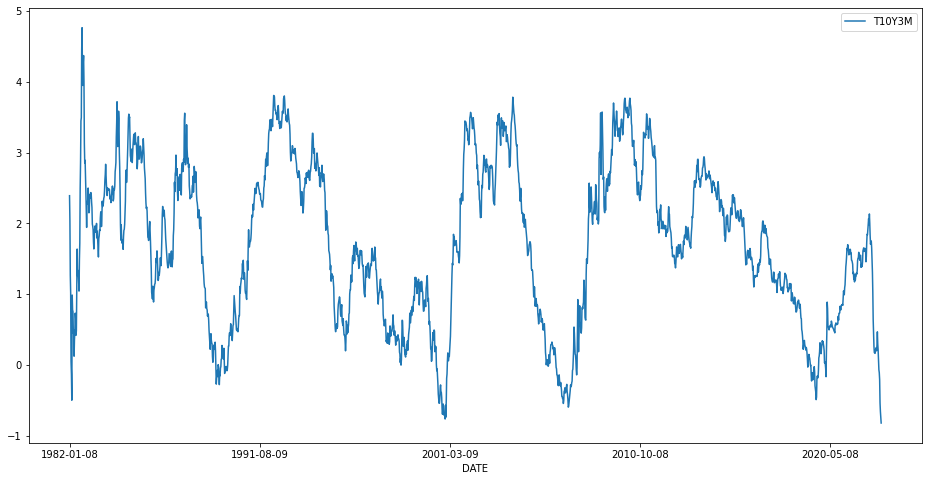

In [4]:
data.plot(figsize = (16,8));

## LSTM Implementation

### Process Data

We will create a model that predicts the rate difference for the next week. For this, the following pre-processing is required.

In [5]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [230]:
# min-max scale
sc = MinMaxScaler()
training_data = sc.fit_transform(data.values)

# using previous 4 weeks
seq_length = 4

x, y = sliding_windows(training_data, seq_length)

<img src="https://trello.com/1/cards/637d5b489ff5ac008a2ad489/attachments/637d6ba532d829019debb8de/download/image.png" width=700>

As shown in the figure above, while sliding the window, we need to connect the data of the past 4 weeks and the future data.

Then, we will set an appropriate ratio as shown below to separate the train/test dataset.

In [231]:
split_ratio = 0.7
train_size = int(len(y) * split_ratio)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

### Define Model and Settings

To use the LSTM network, we need to set the dimensions and other parameters that fit the data we have prepared.

In [232]:
input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

<img src="https://trello.com/1/cards/637d5b489ff5ac008a2ad489/attachments/637d6bbcea5f9800374e23c5/download/image.png" width=700>

In order to learn the parameters of the model, a criterion is needed to define the difference between the predicted value and the actual value of the model. We can set which loss metric to use through `criterion`.

Also, an `optimizer` is needed to adjust the parameters to reduce the loss. Here, we will use <a href="#References" data-toc-modified-id="References-3"><span class="toc-item-num"></span>Adam</a> optimizer.

In [233]:
# Loss and Optimizer Setting
criterion = torch.nn.MSELoss()    # mean-squared error for regression

learning_rate = 0.01
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# You can use other Optimizers
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

### Model Training

By setting the epoch, we can train the model as follows.

In [234]:
num_epochs = 100

# Train the model
for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    outputs = lstm(trainX)

    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.29607
Epoch: 50, loss: 0.03903


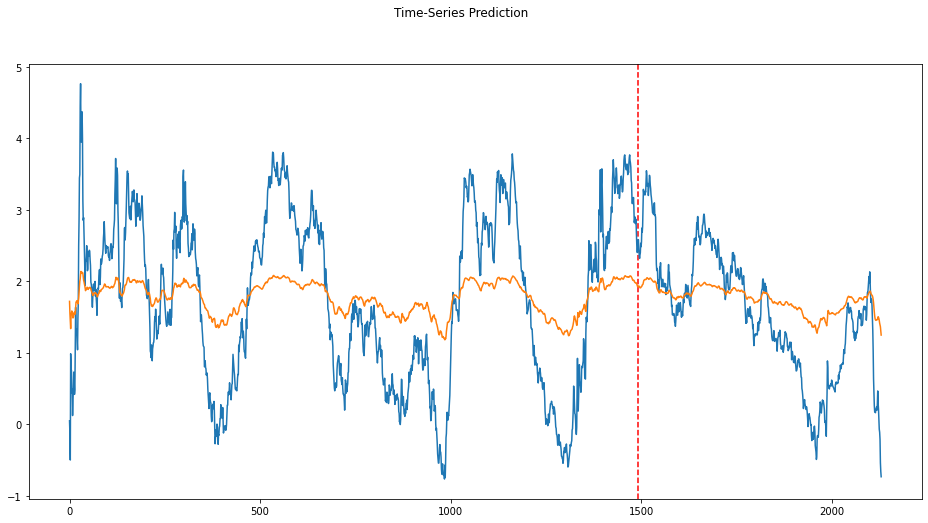

In [235]:
lstm.eval()
with torch.no_grad():
  train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize = (16,8))
plt.axvline(x=len(dataX) * split_ratio, c='r', linestyle='--')
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show();

The predicted values ​​of the model do not explain the actual values ​​well. So, let's move on to further training.

In [236]:
# 100 + 400 = 500 epochs
num_epochs = 400

# Train the model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = lstm(trainX)

    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.03025
Epoch: 50, loss: 0.01804
Epoch: 100, loss: 0.00235
Epoch: 150, loss: 0.00137
Epoch: 200, loss: 0.00125
Epoch: 250, loss: 0.00117
Epoch: 300, loss: 0.00111
Epoch: 350, loss: 0.00106


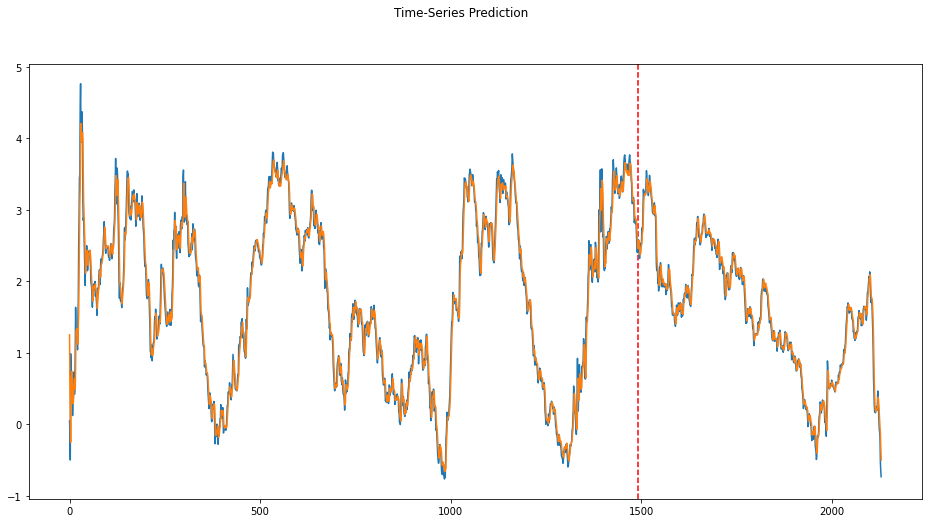

In [227]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize = (16,8))
plt.axvline(x=len(dataX) * split_ratio, c='r', linestyle='--')
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [228]:
lstm.eval()
with torch.no_grad():
  predictions = lstm(testX)
loss_model = criterion(predictions, testY)
print(loss_model)

tensor(0.0004)


## References

Hochreiter, S., & Schmidhuber, J. (1997). [Long short-term memory](http://www.bioinf.jku.at/publications/older/2604.pdf). Neural computation, 9(8), 1735–1780. <br>
Kingma, D.P., & Ba, J. (2015). [Adam: A Method for Stochastic Optimization](https://arxiv.org/pdf/1412.6980.pdf). CoRR, abs/1412.6980. <br>
Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2021). [Dive into Deep Learning](https://d2l.ai/). ArXiv Preprint ArXiv:2106.11342.